# Model Training

In [32]:
# Standard library imports
import joblib
import json
import pathlib
import warnings
warnings.filterwarnings("ignore")

# Third-party library imports
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Read data
data_filepath = pathlib.Path('train.csv')
data = pd.read_csv(data_filepath)

# Create "dummy" columns for categorical data
dummy_column_mapper = {}
for col in data.columns:
    if data[col].dtype == 'object':
        temp = pd.get_dummies(data[col], prefix=col, drop_first=True)
        data = data.drop(columns=[col])
        data[temp.columns] = temp
        dummy_column_mapper[col] = temp.columns.tolist()

# Save mapper for dummy columns
with open('dummy_column_mapper.json', 'w') as fout:
    json.dump(dummy_column_mapper, fout)

# Prepare data for model training
target = 'Exited'
features = [col for col in data.columns if col != target]
binary_columns = [col for col in features if sorted(data[col].unique().tolist()) == [0, 1]]

X = data[features].copy()
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.30, 
    random_state=69,
)

# Save column order of training data
with open('col_order.json', 'w') as fout:
    json.dump(X_train.columns.tolist(), fout)

# Fit scaler
scaler = StandardScaler()
scaler = scaler.fit(X_train)

# Save scaling information
scaler_filepath = pathlib.Path('scaler_info.json')

scaler_dict  = {}
for feature, mean, scale in zip(features, scaler.mean_, scaler.scale_):
    if feature in binary_columns:
        scaler_dict[feature] = {
            'mean': 0,
            'std': 1,
        }
    else:
        scaler_dict[feature] = {
            'mean': mean,
            'std': scale,
        }
        
with open(scaler_filepath, 'w') as fout:
    json.dump(scaler_dict, fout)
    
# Scale data
for col, col_params in scaler_dict.items():
    X_train.loc[:, col] = (X_train.loc[:, col] - col_params['mean'])/col_params['std']
    X_test.loc[:, col] = (X_test.loc[:, col] - col_params['mean'])/col_params['std']

# Fit random forest model
from sklearn.ensemble import RandomForestClassifier

params = {
    'criterion': ['gini', 'entropy'], 
    'max_depth': [2, 5, 10], 
    'n_estimators': [10, 100], 
}


rclf = GridSearchCV(RandomForestClassifier(random_state=0), params, error_score=0)
search = rclf.fit(X_train, y_train)
best_params = search.best_params_ 
best_params

rclf = RandomForestClassifier(random_state=0, **best_params)
rclf = rclf.fit(X_train, y_train) 
rclf.score(X_test, y_test)

gnb = GaussianNB()
gclf = gnb.fit(X_train, y_train)


# Save model
joblib.dump(gclf, 'gclf_model.joblib')

['gclf_model.joblib']

In [33]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6818,0.486367,-1.139297,1.035488,1.043125,0.803623,1.0,0.0,-0.167992,0.0,0.0,1.0
476,-0.041641,0.011293,1.381842,0.568613,-0.917828,1.0,1.0,-1.207336,1.0,0.0,1.0
2117,0.879785,0.011293,-1.388988,-0.250791,-0.917828,1.0,0.0,-1.044089,0.0,1.0,1.0
2352,0.331071,1.257766,-0.003573,0.586155,-0.917828,1.0,0.0,-1.376987,0.0,0.0,0.0
4312,0.848726,0.298941,1.381842,0.523380,0.803623,1.0,1.0,-0.607507,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4374,-0.020935,-0.276354,1.035488,1.134664,0.803623,1.0,1.0,0.518212,0.0,1.0,1.0
8631,-2.277910,-0.755767,-0.003573,-1.217043,-0.917828,1.0,0.0,-0.079908,0.0,0.0,1.0
9818,-0.611061,-0.468119,-0.696281,0.321395,-0.917828,0.0,0.0,-1.205013,0.0,0.0,0.0
4041,0.082596,-0.276354,-1.388988,-1.217043,0.803623,0.0,1.0,-0.266507,0.0,1.0,1.0


# Simulating deployment

In [34]:
new_data = pd.read_csv(data_filepath)

ckey = 0
raw_payload = new_data.loc[ckey].to_dict()
target = raw_payload.pop('Exited')

raw_payload

{'CreditScore': 597,
 'Geography': 'Germany',
 'Gender': 'Female',
 'Age': 35,
 'Tenure': 8,
 'Balance': 131101.04,
 'NumOfProducts': 1,
 'HasCrCard': 1,
 'IsActiveMember': 1,
 'EstimatedSalary': 192852.67}

In [35]:
with open('dummy_column_mapper.json') as fin:
    dummy_column_mapper = json.load(fin)
    
with open('scaler_info.json') as fin:
    scaler_info = json.load(fin)
    
with open('col_order.json') as fin:
    col_order = json.load(fin)
    
payload = dict(raw_payload)
for column, dummy_columns in dummy_column_mapper.items():
    for dummy_column in dummy_columns:
        payload[dummy_column] = 0
    if column in payload:
        column_val = payload.pop(column)
        target_column = f'{column}_{column_val}'
        payload[target_column] = 1
        
for key, scaler_params in scaler_info.items():
    if key in payload:
        payload[key] = (payload[key] - scaler_params['mean'])/scaler_params['std']
    else:
        payload[key] = scaler_params['mean']
        
ordered_payload = {}
for col in col_order:
    ordered_payload[col] = payload[col]
    
prediction = int(gclf.predict(np.array(list(ordered_payload.values())).reshape(1, -1)))

In [36]:
prediction

0

In [37]:
import requests

In [38]:
base_endpoint = 'https://msba-azure-deployment.azurewebsites.net/'

In [39]:
r = requests.get(base_endpoint)
r.text

'App is Healthy'

In [40]:
predict_endpoint = 'https://msba-azure-deployment.azurewebsites.net/predict'

In [41]:
r = requests.post(predict_endpoint, json=raw_payload)
int(r.text)

0

In [42]:
new_data = pd.read_csv(data_filepath)

for ckey in new_data.index.tolist()[:100]:
    raw_payload = new_data.loc[ckey].to_dict()
    target = raw_payload.pop('Exited')
    
    r = requests.post(predict_endpoint, json=raw_payload)
    prediction = int(r.text)
    if prediction == target:
        correct_statement = 'Correct!!!'
    else:
        correct_statement = ''

    print(f'Instance {ckey}: actual->{target}, prediction->{prediction}. {correct_statement}')

Instance 0: actual->0, prediction->0. Correct!!!
Instance 1: actual->1, prediction->0. 
Instance 2: actual->0, prediction->0. Correct!!!
Instance 3: actual->0, prediction->0. Correct!!!
Instance 4: actual->0, prediction->0. Correct!!!
Instance 5: actual->1, prediction->1. Correct!!!
Instance 6: actual->0, prediction->0. Correct!!!
Instance 7: actual->0, prediction->0. Correct!!!
Instance 8: actual->1, prediction->0. 
Instance 9: actual->1, prediction->1. Correct!!!
Instance 10: actual->0, prediction->0. Correct!!!
Instance 11: actual->0, prediction->0. Correct!!!
Instance 12: actual->0, prediction->0. Correct!!!
Instance 13: actual->0, prediction->0. Correct!!!
Instance 14: actual->1, prediction->1. Correct!!!
Instance 15: actual->1, prediction->0. 
Instance 16: actual->0, prediction->0. Correct!!!
Instance 17: actual->0, prediction->0. Correct!!!
Instance 18: actual->0, prediction->0. Correct!!!
Instance 19: actual->0, prediction->0. Correct!!!
Instance 20: actual->0, prediction->0. C

In [44]:
import matplotlib.pyplot as plt

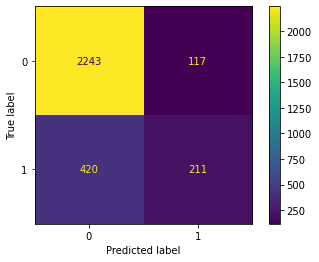

In [45]:
predictions = gclf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=gclf.classes_)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=gclf.classes_,
)
disp.plot()
plt.show()

In [46]:
2243+211

2454

In [47]:
420+117

537

In [48]:
2454/2991

0.8204613841524574